# Central Limit Theorem (CLT) and Normality Testing
My main inspiration for this notebook is [MIT's edX Lecture](https://courses.edx.org/courses/MITx/6.041x_1/1T2015/courseware/Unit_8_Limit_theorems_and_classical_statistics/Lec__19_The_Central_Limit_Theorem__CLT_/) (you might need an edX account to view it). In particular, I wanted to demonstrate the CLT by continuously summing samples of random variables from a non-normal distribution, _i.e._ an exponential or uniform distribution.

The question arises: how many times do you need to sum samples from a non-normal distribution to get "close enough" to a normal distribution? I explore a number of [normality tests](#stat_testing).

In math terms, let $X$ be a random variable:

$$
\begin{align} S_n &= X_1 + X_2 + \dots + X_n \\[1.5ex]
Z_n &= \frac{S_n - n \mu}{\sigma \sqrt{n}} \end{align}
$$

where $X_i$s are i.i.d.

The CLT states:

Let $Z$ be a standard normal RV: $Z \sim \mathcal{N}(\mu = 0, \sigma = 1)$.

$$ \forall z: \lim_{n \to \infty} P(Z_n \le z) = P(Z \le z) $$

At what value of $n$ does $P(Z_n \le z) \approx P(Z \le z)$?

# Imports and Definitions

In [59]:
%matplotlib inline
import warnings
warnings.simplefilter('once', UserWarning)

import numpy as np
import matplotlib.pyplot as plt

from cycler import cycler # for plot colors
from scipy import stats

np.random.seed(56) # ensure reproducibility
plt.close('all')

# Globals
samples = int(5e3) # n > 5000 gives warnings about p-values
res = 1e-4

# Define standard normal distribution
N = stats.norm(loc=0, scale=1)

## Define the Test Distribution
Feel free to experiment with any of these [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/stats.html) distributions! Distributions that are asymmetrical or have fat tails will give a more pronounced effect.

In [60]:
# Uniform
# a = 1
# b = 9 # s.t. pdf = 1/8 = 0.125
# dist = stats.uniform(loc=a, scale=b-a)     # ~ dist[loc, loc+scale]

# Exponential
lam = 1
dist = stats.expon(scale=1/lam)
# scale = 1/lambda for f(x) = lambda * exp(-lambda*x)

# Convolve Samples From A Distribution

My major open question in this simple function arises in the normalization factors. Do $\mu$ = `dist.mean()` and $\sigma^2$ = `dist.var()` need to be known from the underlying distribution of our sample (which is not normally known)?

In [61]:
def convolve_dist(dist, n, samples=1000, norm_out=True):
    """Convolve a distribution n times.
    For a random variable X, 
        Sn = X1 + X2 + ... + Xn

    Parameters
    ----------
    dist : rv_continuous
        continuous distrubution object, i.e. scipy.stats.norm
    n : int
        number of convolutions to make
    samples : int, optional, default=1000
        number of samples to draw for each convolution
    norm_out : boolean, optional, default=True
        normalize output to Z-score: (S - n*dist.mean()) / np.sqrt(n*dist.var())
    
    Returns
    -------
    out : ndarray, shape (samples,)
        if norm_out, out = Zn values, otherwise out = Sn values
    """
    Sn = np.zeros(samples)
    for i in range(n):
        # Draw from distribution and add to sum
        Sn += dist.rvs(size=samples)

    if norm_out:
        Zn = (Sn - n*dist.mean()) / np.sqrt(n*dist.var()) # normalize Sn
        return Zn
    else:
        return Sn

## Plot the pdf of the test distribution

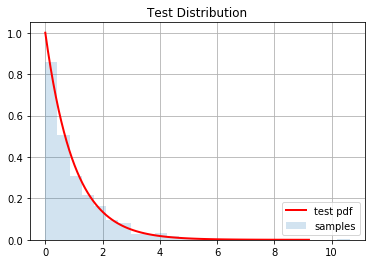

In [62]:
# Draw samples on the range where pdf has support
x = np.linspace(dist.ppf(res), dist.ppf(1-res), 100)

fig = plt.figure(1)
fig.clf()
ax = plt.gca()
ax.set_title('Test Distribution')
ax.plot(x, dist.pdf(x), 'r-', label='test pdf')

# Draw from the distribution and display the histogram
r = dist.rvs(size=1000)
ax.hist(r, density=True, bins=25, histtype='stepfilled', alpha=0.2, label='samples')
ax.legend(loc='lower right')
plt.show()

## Demonstrate CLT
The following plot shows our test distribution vs. a standard normal for values of $n \in \{1, 2, 10, 30\}$. The convolution gets astoundingly close to normal at $n = 30$, even for the heavily skewed exponential distribution.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


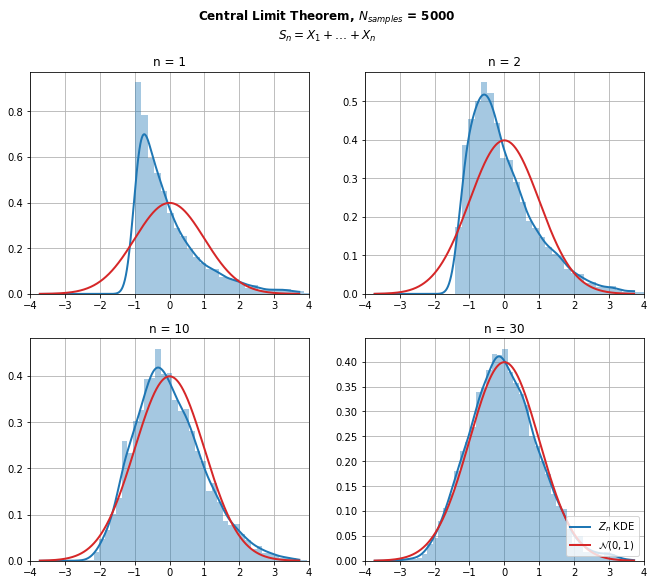

In [63]:
#------------------------------------------------------------------------------ 
#        Plots vs. n
#------------------------------------------------------------------------------
# Plot histogram of samples vs normal distribution
fig = plt.figure(2, figsize=(11,9))

xN = np.linspace(N.ppf(res), N.ppf(1-res), 1000)

n_arr = [1, 2, 10, 30]
for i in range(len(n_arr)):
    # Convolve the pdfs
    Zn = convolve_dist(dist, n=n_arr[i], samples=samples)
    Nn = stats.gaussian_kde(Zn)   # compare to actual normal

    # Plot vs standard normal distribution
    ax = fig.add_subplot(2, 2, i+1)
    sns.distplot(Zn, kde=False, norm_hist=True, ax=ax)
    ax.plot(xN, Nn.pdf(xN), 'C0', label='$Z_n$ KDE')
    ax.plot(xN, N.pdf(xN), 'C3', label='$\mathcal{N}(0,1)$')
    ax.set_xlim([-4, 4])
    # ax.set_ylim([0, 1.25*max(Nn.pdf(xN))])
    ax.set_title("n = {}".format(n_arr[i]))

fig.suptitle(("Central Limit Theorem, $N_{{samples}}$ = {}\n" + \
             "$S_n = X_1 + \dots + X_n$").format(samples))
ax.legend(loc='lower right')
plt.show()

<a id="stat_testing"></a>
## Determine $n$ Using Normality Tests
Tests employed are:
* [Kolmogorov-Smirnov (K-S) Test `kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest)
* [Shapiro-Wilk Test `shapiro`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro)
* [D'Agostino-Pearson Test `normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest)
* [Anderson-Darling Test `anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson)

In all but the Anderson test, the null hypothesis is that the sample is drawn from the reference distribution (standard normal in this case). The Shaprio and D'Agostino tests are specific to normality testing. The others may be used to compare with _any_ reference distribution.

The $D$ statistic for the K-S test should approach 0 for a true normal distribution. The $W$ statistic for the Shapiro-Wilk test should approach 1, so I have plotted $1-W$ to compare with the other statistics. The $K$ statistic of the D'Agostino-Pearson test (`normaltest`) is not bound, so I have scaled it by its maximum value for comparison with the other statistics.

**Each test is plotted vs. $n$ convolutions of the test distribution, so $n = 1$ is just an exponential distribution (or whatever you chose for the test).**

I got some odd results with a [chi-squared test `chisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare) (lines commented out below).

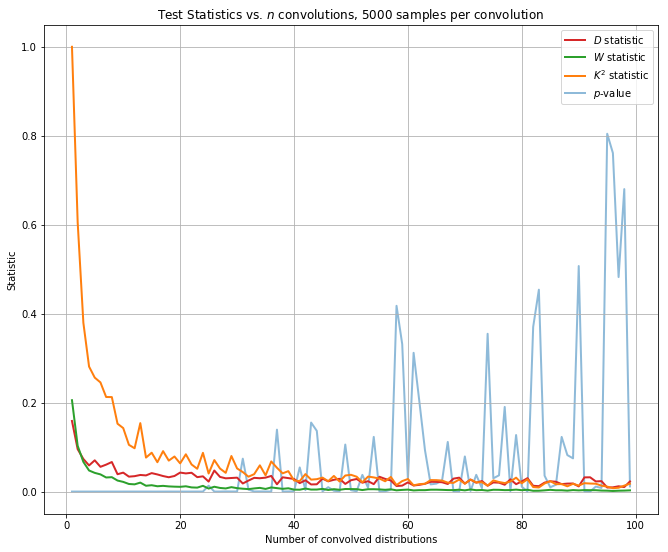

In [64]:
#------------------------------------------------------------------------------ 
#        Determine n to match N(0,1)
#------------------------------------------------------------------------------
# Draw from distrubution until we approach a standard normal
MAX_N = 100
#thresh = 1 - 1e-3
score = np.inf
n = 1
D = np.empty(MAX_N)
W = np.empty(MAX_N)
A = np.empty(MAX_N)
K = np.empty(MAX_N)
p = np.empty(MAX_N)
# X2 = np.empty(MAX_N)
D.fill(np.nan)
A.fill(np.nan)
W.fill(np.nan)
K.fill(np.nan)
p.fill(np.nan)
# X2.fill(np.nan)
Zn = []
while n < MAX_N:
    # Compute convolution
    Zn.append(convolve_dist(dist, n=n, samples=samples))
    # Test if convolution is equivalent to normal distribution
    D[n], p[n] = stats.kstest(Zn[-1], 'norm')
    W[n], _ = stats.shapiro(Zn[-1])
    A[n], cv, sig = stats.anderson(Zn[-1], dist='norm')
    K[n], _ = stats.normaltest(Zn[-1])
    # # Chi-squared test requires bins of data
    # Zn_hist, _ = np.histogram(Zn[-1], bins=100, density=True)
    # N_hist, _ = np.histogram(N.rvs(size=100000), bins=100, density=True)
    # X2[n], _ = stats.chisquare(f_obs=Zn_hist, f_exp=N_hist)
    # # Possible test if we've reached an acceptable threshold value:
    #if W[n] > thresh:
    #    break
    n += 1

# Plot test statistics vs. n
plt.figure(9, figsize=(11,9))
plt.clf()
ax = plt.gca()
ax.plot(np.arange(MAX_N), D, c='C3', label='$D$ statistic')
ax.plot(np.arange(MAX_N), 1-W, c='C2', label='$W$ statistic')
# ax.plot(np.arange(MAX_N), X2/np.nanmax(X2), c='C4', label='$\chi^2$ statistic')
ax.plot(np.arange(MAX_N), K/np.nanmax(K), c='C1', label='$K^2$ statistic')
ax.plot(np.arange(MAX_N), p, c='C0', label='$p$-value', zorder=0, alpha=0.5)
# ax.set_yscale('log')
ax.set_title('Test Statistics vs. $n$ convolutions, {} samples per convolution'.format(samples))
ax.set_xlabel('Number of convolved distributions')
ax.set_ylabel('Statistic')
# ax.set_ylim([0, 2])
ax.legend(loc='upper right')
plt.show()

### Results
We note each of the statistics starts at a large value, then decays rapidly towards 0 as we approach a normal distribution. The $p$-value gets quite noisy for large $n$ values. I am unsure why that is the case, and of how to interpret the $p$-value in conjunction with the test statistics.

### Anderson-Darling Test
This test statistic has a slightly different interpretation. If $A^2$ is larger than a given threshold, the null hypothesis that the data come from the chosen (normal) distribution can be rejected at corresponding significance level. The Anderson test is ([according to Wikipedia](https://en.wikipedia.org/wiki/Anderson–Darling_test)) more sensitive in the tails of the distribution.

For an exponential test distribution, the test statistic is _larger_ than all of the critical values until about $n = 95$, so we reject the null hypothesis that the data come from a normal distribution. It seems the Anderson test is **most stringent** when performing normality testing.

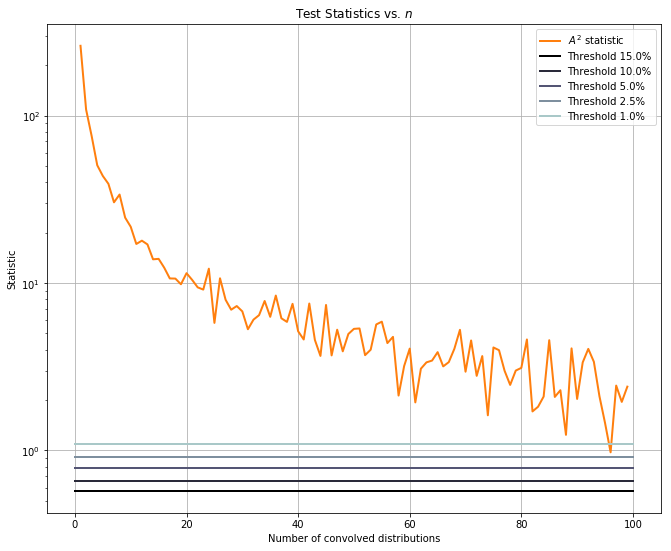

In [65]:
# Plot A^2 statistic (Anderson-Darling test)
# If A^2 is larger than critical value for corresponding significance level,
# the null hypothesis that the data come from the chosen distribution can be
# rejected
plt.figure(10, figsize=(11,9))
ax = plt.gca()
ax.plot(np.arange(MAX_N), A, c='C1', label='$A^2$ statistic')
# Use greys for threshold values
ax.set_prop_cycle(cycler('color',
                         [plt.cm.bone(i) for i in np.linspace(0, 0.75, 5)]))
for i in range(5):
    ax.plot(np.array([0, n]), cv[i]*np.array([1, 1]),
            label='Threshold {}%'.format(sig[i]))
ax.set_yscale('log')
ax.set_title('Test Statistics vs. $n$')
ax.set_xlabel('Number of convolved distributions')
ax.set_ylabel('Statistic')
ax.legend(loc='upper right')
plt.show()

## Q-Q Plot
Lastly, we can plot the [quartile-quartile plot](https://en.wikipedia.org/wiki/Q–Q_plot) of the samples from our test distribution vs. the expected values from a normal distribution. The darker colors are higher $n$ values, which show the approach to the straight red line (true standard normal).

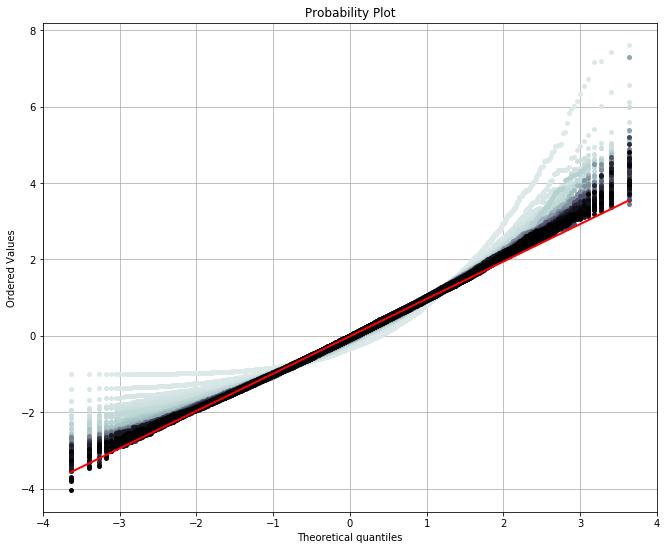

In [66]:
plt.figure(11, figsize=(11,9))
ax = plt.gca()
colors = [plt.cm.bone(i) for i in np.linspace(0, 0.9, len(Zn))][::-1]
for i in range(len(Zn)):
    result = stats.probplot(Zn[i], dist='norm', plot=ax) # Q-Q plot
    ax.get_lines()[2*i].set_markeredgecolor('none')
    ax.get_lines()[2*i].set_markerfacecolor(colors[i])
    # Turn off all but last fit line
    if i < len(Zn)-1:
        ax.get_lines()[2*i+1].set_linestyle('none')
plt.show()